In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
# Data retreival function
def data_collect(csv_file):
    data=pd.read_csv(csv_file)
    data_arr=np.array(data)
    y_data=[]
    for i in range(data_arr.shape[0]):
     y_data.append(data_arr[i][0])
    y_data=np.array(y_data)
    x=[]
    for i in range(data_arr.shape[0]):
     x.append(np.delete(data_arr[i] , 0))
    x_data=np.array(x) 
    x_data=torch.tensor(x_data, dtype=torch.float32)
    y_data=torch.tensor(y_data, dtype=torch.float32)
    return x_data,y_data

x_data , y_data = data_collect('mnist_train.csv')    
    

In [3]:
x_train,x_val,y_train,y_val = train_test_split(x_data,y_data, train_size=0.80, random_state=42)

In [4]:
train_dataset=TensorDataset(x_train,y_train)
train_data_loader=DataLoader(train_dataset , batch_size=64, shuffle=True)

valid_dataset = TensorDataset(x_val,y_val)
val_data_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [5]:
# Model
class Perceptron(nn.Module):
    def __init__(self, input_size,num_class,activation_func, batch_first=False):
        super(Perceptron,self).__init__()
        self.activation_func = activation_func
        self.L1 = nn.Linear(input_size , 256)
        self.L2 = nn.Linear(256,128)
        self.L3 = nn.Linear(128,32)
        self.L4 = nn.Linear(32,16)
        self.L5 = nn.Linear(16,num_class)
        self.sigmoid=nn.Sigmoid()
        self.relu = nn.ReLU()
        self.activation = self.sigmoid if self.activation_func == 'sigmoid' else self.relu
            

    def forward(self, data):
        out = self.activation(self.L1(data))
        out = self.activation(self.L2(out))
        out = self.activation(self.L3(out))
        out = self.activation(self.L4(out))
        out = self.L5(out)
        return out

# Training


def train_model(model, train_dataload , validation_dataload, num_epochs, learning_rate):
    
    train_loss_list = []
    val_loss_list = []
    train_accu_list = []
    val_accu_list = []
    
    criterion = nn.CrossEntropyLoss(reduction='mean')  # Binary Cross entropy for Classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        total_loss = 0
        correct_prediction = 0
        total_samples = 0
    
    # Training phase    
        for data,target in train_dataload: 
         data , target = data.float() , target.long()
         optimizer.zero_grad()
         outputs = model(data)
         loss = criterion(outputs, target)
         loss.backward()
         optimizer.step()
         total_loss += loss.item()
         
         _,predicted = torch.max(outputs,1) # This line would depend on the model itself, as output may vary with respect to the model.
         correct_prediction+=(predicted==target).sum().item()
         total_samples+=target.size(0)
         
        
        train_avg_loss = total_loss / len(train_dataload)
        training_accuracy = (correct_prediction / total_samples)*100 
        
        train_loss_list.append(train_avg_loss)
        train_accu_list.append(training_accuracy)
    
    # Evaluation phase
        model.eval()
        val_correct = 0
        total_val_loss=0
        val_samples = 0
        for val_data,val_target in validation_dataload:
            val_data,val_target = val_data.float() , val_target.long()
            val_output = model(val_data)
            val_loss = criterion(val_output,val_target)
            total_val_loss+=val_loss.item()
            
            _,val_predicted = torch.max(val_output,1) # This line would depend on the model itself, as output may vary with respect to the model.
            val_correct+=(val_predicted == val_target).sum().item()
            val_samples+=val_target.size(0)
            
        val_avg_loss = total_val_loss / len(validation_dataload) 
        validattion_accuracy = (val_correct / val_samples)*100   
        
        val_loss_list.append(val_avg_loss)
        val_accu_list.append(validattion_accuracy)
            
            
        if epoch % 10 == 0:    
            print(f'E:{epoch}/{num_epochs}, Train_loss:{train_avg_loss:.5f}, TrainAcc.: {training_accuracy:.2f}, ValLoss: {val_avg_loss:.2f}, ValAccu: {validattion_accuracy:.2f}')

    print(f'Total number of epochs: {num_epochs}, Training completed with {model.activation_func} function')
    return train_loss_list,train_accu_list,val_loss_list,val_accu_list


In [6]:
model_sigmoid = Perceptron(input_size=x_train.shape[1], num_class = 10, activation_func='sigmoid')  # Input size should match x_train features

# Train the model
karpathy_constant = 3e-4
total_epochs = 100
sigmoid_train_loss , sigmoid_train_accu , sigmoid_val_loss, sigmoid_val_accu = train_model(model_sigmoid, train_data_loader ,val_data_loader, num_epochs=total_epochs, learning_rate = karpathy_constant) 

  0%|          | 0/100 [00:00<?, ?it/s]

E:0/100, Train_loss:2.08111, TrainAcc.: 30.95, ValLoss: 1.77, ValAccu: 55.33
E:10/100, Train_loss:0.26386, TrainAcc.: 93.58, ValLoss: 0.27, ValAccu: 93.70
E:20/100, Train_loss:0.17321, TrainAcc.: 95.43, ValLoss: 0.20, ValAccu: 94.34
E:30/100, Train_loss:0.13826, TrainAcc.: 96.12, ValLoss: 0.17, ValAccu: 95.36
E:40/100, Train_loss:0.11753, TrainAcc.: 96.58, ValLoss: 0.15, ValAccu: 95.98
E:50/100, Train_loss:0.10173, TrainAcc.: 97.03, ValLoss: 0.14, ValAccu: 95.97
E:60/100, Train_loss:0.09163, TrainAcc.: 97.29, ValLoss: 0.14, ValAccu: 96.16
E:70/100, Train_loss:0.07905, TrainAcc.: 97.69, ValLoss: 0.13, ValAccu: 96.49
E:80/100, Train_loss:0.06535, TrainAcc.: 98.07, ValLoss: 0.12, ValAccu: 96.52
E:90/100, Train_loss:0.06037, TrainAcc.: 98.18, ValLoss: 0.12, ValAccu: 96.95
Total number of epochs: 100, Training completed with sigmoid function


In [7]:
model_relu = Perceptron(input_size=x_train.shape[1], num_class = 10, activation_func='ReLU')

# Train the model
karpathy_constant = 3e-4
total_epochs = 100
relu_train_loss , relu_train_accu , relu_val_loss, relu_val_accu = train_model(model_relu, train_data_loader ,val_data_loader, num_epochs=total_epochs, learning_rate = karpathy_constant)

  0%|          | 0/100 [00:00<?, ?it/s]

E:0/100, Train_loss:0.31136, TrainAcc.: 90.58, ValLoss: 0.15, ValAccu: 95.57
E:10/100, Train_loss:0.02130, TrainAcc.: 99.28, ValLoss: 0.09, ValAccu: 97.91
E:20/100, Train_loss:0.01019, TrainAcc.: 99.66, ValLoss: 0.12, ValAccu: 97.69
E:30/100, Train_loss:0.00843, TrainAcc.: 99.75, ValLoss: 0.15, ValAccu: 97.45
E:40/100, Train_loss:0.00470, TrainAcc.: 99.86, ValLoss: 0.13, ValAccu: 98.09
E:50/100, Train_loss:0.00732, TrainAcc.: 99.81, ValLoss: 0.15, ValAccu: 97.93
E:60/100, Train_loss:0.00495, TrainAcc.: 99.87, ValLoss: 0.14, ValAccu: 97.96
E:70/100, Train_loss:0.00349, TrainAcc.: 99.91, ValLoss: 0.15, ValAccu: 98.20
E:80/100, Train_loss:0.00538, TrainAcc.: 99.88, ValLoss: 0.14, ValAccu: 97.98
E:90/100, Train_loss:0.00163, TrainAcc.: 99.94, ValLoss: 0.14, ValAccu: 98.41
Total number of epochs: 100, Training completed with ReLU function


In [11]:
def graph_plots(model,total_epochs,*args):
    x_variable = np.arange(total_epochs)
    fig,ax = plt.subplots(1,2, figsize=(15,5))

    ax[0].plot(x_variable,args[0], label='Training loss')
    ax[0].plot(x_variable,args[1], label='Validation loss')
    ax[0].legend()
    ax[0].set_xlabel('Number of epochs', fontsize=12)
    ax[0].set_title('Loss Value graphs')

    ax[1].plot(x_variable, args[2], label='Training accuracy')
    ax[1].plot(x_variable, args[3], label='Validation accuracy')
    ax[1].legend()
    ax[1].set_xlabel('Number of epochs', fontsize=12)
    ax[1].set_title('Accuracy graphs')

    fig.suptitle(f'Using {model.activation} activation function')
    plt.show()


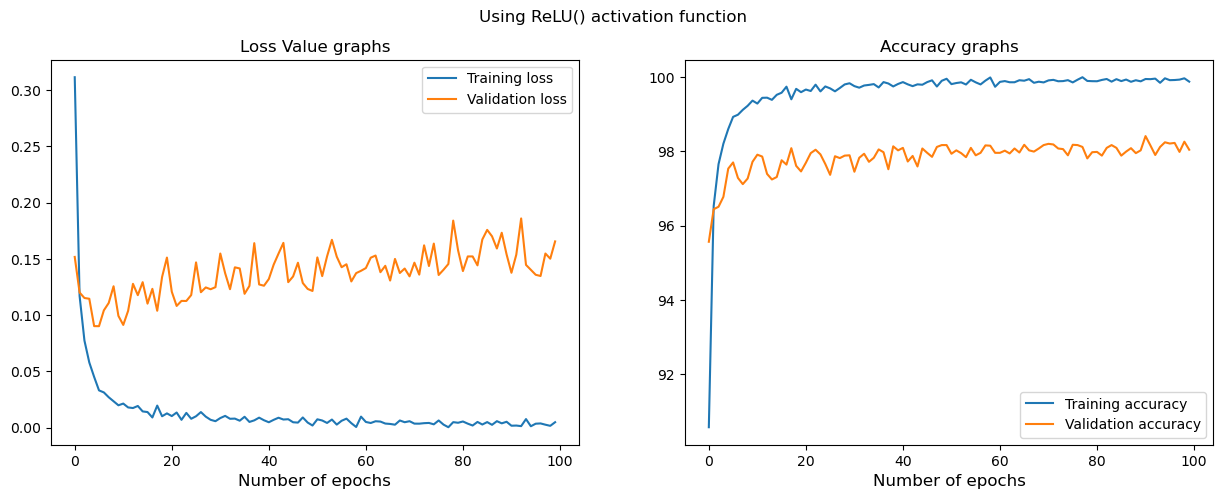

In [12]:
label = (relu_train_loss, relu_val_loss, relu_train_accu, relu_val_accu)
graph_plots(model_relu, total_epochs, *label)


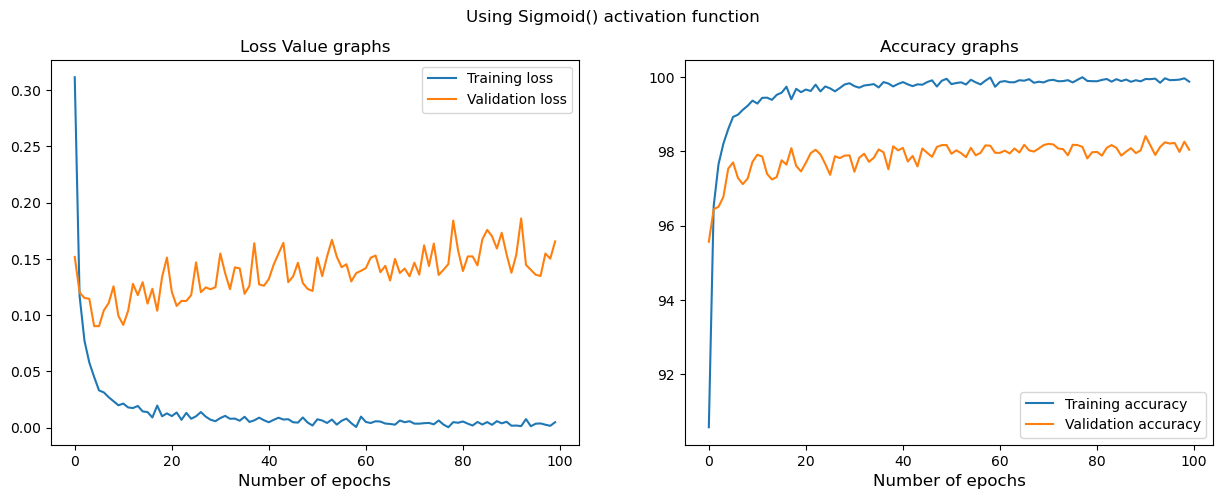

In [13]:
labels = (sigmoid_train_loss, sigmoid_val_loss, sigmoid_train_accu, sigmoid_val_accu)
graph_plots(model_sigmoid, total_epochs, *label)